# Prerequisites

### Install & import packages

In [40]:
! pip install efficientnet_pytorch

In [5]:
import tarfile
import torchvision
from torchvision import transforms
from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm, trange
import pandas as pd
import os
import shutil
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print("Training on: " + torch.cuda.get_device_name(0))

cuda:0
Training on: Tesla P100-PCIE-16GB


### Mount Drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/ails_challenge_3/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Unzip folder into temporary storage (loads faster than from google drive)

In [8]:
# training data
tar = tarfile.open(path + "images_train.tar")
tar.extractall()
tar.close()

# submission data
tar = tarfile.open(path + "images_test.tar")
tar.extractall()
tar.close()

# Utility Functions

In [9]:
def plot_metrics(train_errors, valid_errors):
  x = np.arange(1, len(train_errors)+1)
  fig = plt.figure(figsize=(20,5))
  ax = fig.add_subplot(131, label="train")
  ax.plot(x, train_errors, color="C0", label="training loss")
  ax.plot(x, valid_errors, color="C1", label="validation loss")
  ax.set_ylabel("Loss")
  ax.set_xlabel("Epoch")        
  ax.xaxis.grid(False)  
  ax.legend()

  plt.show()

In [10]:
# code taken from https://forums.fast.ai/t/normalizing-your-dataset/49799
def online_mean_and_std(loader):
  """Compute the mean and std in an online fashion

      Var[x] = E[X^2] - E^2[X]
  """
  cnt = 0
  fst_moment = torch.empty(3)
  snd_moment = torch.empty(3)

  for images, _ in loader:

    b, c, h, w = images.shape
    nb_pixels = b * h * w
    sum_ = torch.sum(images, dim=[0, 2, 3])
    sum_of_square = torch.sum(images ** 2, dim=[0, 2, 3])
    fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
    snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)

    cnt += nb_pixels

  return fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)

# Data

In [19]:
class ImageDataset(Dataset):

  def __init__(self, path, transform=None, train=True, submission=False):
    super().__init__()
    self.path = path
    self.transform = transform
    self.train = train
    self.file_ids = []
    if submission:
      self.folder = 'images_test/'
      self.start_id, self.end_id = 9633, int(len(os.listdir('images_test')) / 3) + 9633
      self.images, self.labels = self.get_images(), 0 # labels are not needed here
    else:
      self.folder = 'images_train/'
      self.start_id, self.end_id = 1, int(len(os.listdir('images_train')) / 3) + 1
      self.images, self.labels = self.train_test_split(self.get_images(), self.get_labels())

  def load_image_data(self, file_id):
    image_channels = []
    colors = ['yellow', 'red', 'blue']
    for color in colors:
      n_digits = len(str(file_id))
      n_zeros = 5 - n_digits
      with Image.open(self.folder + '{}{}_{}.png'.format('0'*n_zeros, file_id, color)) as img:
        channel = img.convert('L')
      image_channels.append(np.asarray(channel))
    return image_channels
       
  def get_images(self):
    images = []
    for file_id in trange(self.start_id, self.end_id, position=0):
      image_channels = self.load_image_data(file_id)
      image = self.merge_channels(image_channels)
      images.append(image)
      self.file_ids.append(file_id)
    return images

  def merge_channels(self, image_channels):
    rgb = np.dstack((image_channels[0], image_channels[1], image_channels[2])) 
    return rgb

  def get_labels(self):
    labels = pd.read_csv(self.path + 'y_train.csv')
    unique_labels = list(labels.cell_line.unique())
    tokenized_unique_labels = list(range(len(unique_labels)))
    self.label2token = dict(zip(unique_labels, tokenized_unique_labels))
    self.token2label = dict(zip(tokenized_unique_labels, unique_labels))
    labels = list(labels.cell_line)
    tokenized_labels = [self.label2token[label] for label in labels]
    return tokenized_labels

  def train_test_split(self, images, labels):
    images_train, images_test, labels_train, labels_test = train_test_split(images, labels, stratify=labels, shuffle=True, test_size=0.3, random_state=42)
    if self.train:
      return images_train, labels_train
    else:
      return images_test, labels_test

  def __getitem__(self, idx):
    image = self.images[idx]
    label = self.labels[idx]
    if self.transform:
      image = self.transform(image)
    return (image, label)

  def __len__(self):
    return len(self.images)


### Get mean and std of dataset

In [12]:
# create a dataloader to get mean and std for normalization
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize(224),
                                ])
data = ImageDataset(path, transform, train=True)
dataloader = DataLoader(data, batch_size=1, shuffle=False)
mean, std = online_mean_and_std(dataloader)
print(mean, std)

100%|██████████| 9632/9632 [00:05<00:00, 1750.24it/s]


tensor([0.1474, 0.1322, 0.1288]) tensor([0.1532, 0.1565, 0.2173])


### Create train and validation dataset

In [20]:
# create train and validation set with the obtained normalization values
transform_train = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize(224),
                                transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
                                transforms.RandomVerticalFlip(0.6),
                                transforms.RandomHorizontalFlip(0.6),
                                transforms.RandomRotation(degrees=45),
                                transforms.Normalize(mean, std)
                                ])

transform_val = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize(224),
                                transforms.Normalize(mean, std)
                                ])

data_train = ImageDataset(path, transform_train, train=True)
data_val = ImageDataset(path, transform_val, train=False)

100%|██████████| 9632/9632 [00:05<00:00, 1855.46it/s]


### Visualize Data

Text(0.5, 1.0, 'label distribution in train & val data')

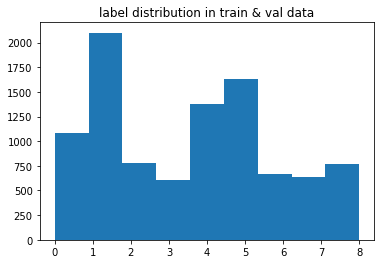

In [52]:
plt.hist(data_train.labels + data_val.labels, 9);
plt.title('label distribution in train & val data')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


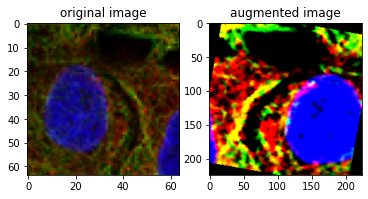

In [27]:
# check images
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data_train.images[0]);
ax1.set_title('original image');
ax2.imshow(data_train[0][0].permute(1,2,0));
ax2.set_title('augmented image');

# Network

In [41]:
class CNN(nn.Module):

  def __init__(self):
    super(CNN, self).__init__()
    self.features = EfficientNet.from_pretrained('efficientnet-b1', num_classes=9)

  def forward(self, x):
    x = self.features(x)
    return x

### Take a look at the network layers

In [42]:
network = CNN()
print(network)

Loaded pretrained weights for efficientnet-b1
CNN(
  (features): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_pa

### Evaluate and update function

In [29]:
def get_error(network, dataloader, loss):
  for x, y in dataloader:
    x, y = x.to(device), y.to(device)
    
    y_pred = network(x)
    err = loss(y_pred, y)
    del(x, y)
    yield err

In [30]:
@torch.no_grad()
def evaluate(network, dataloader, loss, epoch):

  network.eval()
  errors = []

  with tqdm(get_error(network, dataloader, loss), leave=True, unit=" batches", position=0, total=len(dataloader)) as pbar:
    for i, err in enumerate(pbar):
      n_batches = len(pbar)
      pbar.set_description('epoch {}: validation loss {}'.format(epoch, round(err.item(), 4)))
      errors.append(err.item())

      if i == n_batches-1:
        mean_err = sum(errors) / len(errors)
        pbar.set_description('epoch {}: mean validation loss {}'.format(epoch, round(mean_err, 4)))
  pbar.close()
  return mean_err

In [31]:
@torch.enable_grad()
def update(network, dataloader, loss, opt, epoch):
  network.train()
  errors = []

  with tqdm(get_error(network, dataloader, loss), leave=True, unit=" batches", position=0, total=len(dataloader)) as pbar:
    n_batches = len(pbar)
    for i, err in enumerate(pbar):
      network.zero_grad()
      err.backward()
      opt.step()

      pbar.set_description('epoch {}: training loss {}'.format(epoch, round(err.item(), 4)))
      errors.append(err.item())

      if i == n_batches-1:
        mean_err = sum(errors) / len(errors)
        pbar.set_description('epoch {}: mean training loss {}'.format(epoch, round(mean_err, 4)))

  pbar.close()
  return mean_err

# Training

In [32]:
# Parameters
batch_size = 64
epochs = 30
lr = 7e-5
weight_decay = 1e-6

In [33]:
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(data_val, batch_size=1, shuffle=True)

network = network.to(device)

opt = torch.optim.Adam(network.parameters(), lr=lr, weight_decay=weight_decay)
loss = nn.CrossEntropyLoss()    

train_errs, valid_errs = [], []
for epoch in trange(epochs):
    train_err = update(network, train_loader, loss, opt, epoch)
    train_errs.append(train_err)

    # validation
    val_err = evaluate(network, val_loader, loss, epoch)
    valid_errs.append(val_err)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth



Loaded pretrained weights for efficientnet-b1


100%|██████████| 30/30 [1:01:54<00:00, 123.82s/it]


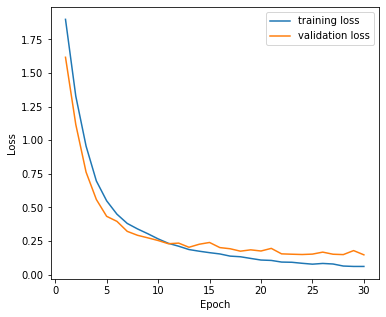

In [34]:
plot_metrics(train_errs, valid_errs)

### Check balanced accuracy score on validation set

In [35]:
# get local balanced accuracy score
predictions = []
targets = []
for x, y in val_loader:
  x = x.to(device) 
  prediction = network(x)
  p = F.softmax(prediction, dim=1)
  prediction = torch.max(p, 1)[1].cpu().numpy()
  predictions.append(prediction)
  targets.append(y)

balanced_accuracy_score(torch.Tensor(targets), torch.Tensor(predictions)) 

0.9433327418966875

# Submission

In [36]:
# create submission dataloader
data_sub = ImageDataset(path, transform_val, submission=True)
sub_loader = DataLoader(data_sub, batch_size=1, shuffle=False)

100%|██████████| 6869/6869 [00:03<00:00, 1815.58it/s]


In [37]:
# get predictions for each sample in sub_loader
predictions = []
for x, _ in sub_loader:
  x = x.to(device) 
  prediction = network(x)
  p = F.softmax(prediction, dim=1)
  prediction = torch.max(p, 1)[1].cpu().numpy()
  predictions.append(prediction)

prediction_tokens= [int(i[0]) for i in torch.Tensor(predictions).tolist()]
prediction_labels = [data_sub.token2label[token] for token in prediction_tokens]

Text(0.5, 1.0, 'distribution of submission labels')

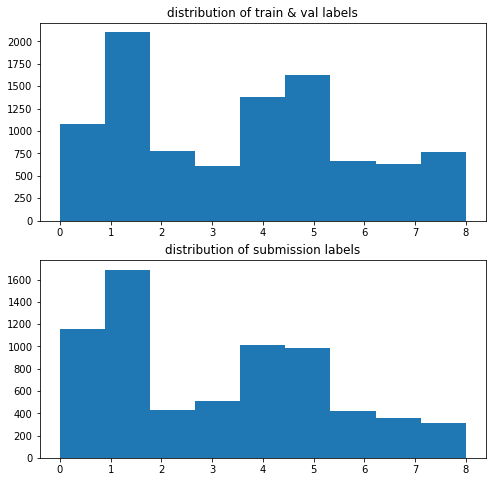

In [38]:
# visual check of label distributions
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.hist(data_train.labels + data_val.labels, 9);
ax1.set_title('distribution of train & val labels')
ax2.hist(torch.Tensor(prediction_tokens), 9);
ax2.set_title('distribution of submission labels')

In [39]:
# save .csv file
df = pd.DataFrame(prediction_labels, index=data_sub.file_ids, columns =['cell_line']).rename_axis('file_id')
df.to_csv('submission.csv')
df

,cell_line
file_id,
9633,U-251 MG
9634,CACO-2
9635,CACO-2
9636,MCF7
9637,HEK 293
...,...
16497,HEK 293
16498,HEK 293
16499,RT4
